# Import Section & Set Variables

In [122]:
import numpy as np
import pandas as pd
import sklearn.model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import RegressorChain
import matplotlib.pyplot as plt

%matplotlib inline

fname = "Apple.csv"
sel_region = "Sacramento"

WINDOWS = [15, 20, 25, 40]

# Preprocess Dataset

In [123]:
df = pd.read_csv(fname)
df

,Date,Small size,Large,type,year,region
0,27/12/2015,1036.74,54454.85,conventional,2015,Albany
1,20/12/2015,674.28,44638.81,conventional,2015,Albany
2,13/12/2015,794.70,109149.67,conventional,2015,Albany
3,6/12/2015,1132.00,71976.41,conventional,2015,Albany
4,29/11/2015,941.48,43838.39,conventional,2015,Albany
...,...,...,...,...,...,...
18244,4/2/2018,2046.96,1529.20,organic,2018,WestTexNewMexico
18245,28/1/2018,1191.70,3431.50,organic,2018,WestTexNewMexico
18246,21/1/2018,1191.92,2452.79,organic,2018,WestTexNewMexico
18247,14/1/2018,1527.63,2981.04,organic,2018,WestTexNewMexico


# Split Data Into Two Categories: "conventional" and "organic"

In [124]:
df = df[df["region"] == sel_region]
df = df.rename(columns={'Small size': 'Small'})

df_conventional = df[df["type"] == "conventional"]
df_organic = df[df["type"] == "organic"]

df

,Date,Small,Large,type,year,region
2080,27/12/2015,98482.89,249362.94,conventional,2015,Sacramento
2081,20/12/2015,99604.61,224843.47,conventional,2015,Sacramento
2082,13/12/2015,94854.90,221627.68,conventional,2015,Sacramento
2083,6/12/2015,82537.98,184349.52,conventional,2015,Sacramento
2084,29/11/2015,80757.92,216851.97,conventional,2015,Sacramento
...,...,...,...,...,...,...
18088,4/2/2018,2722.60,4194.00,organic,2018,Sacramento
18089,28/1/2018,2280.40,3098.00,organic,2018,Sacramento
18090,21/1/2018,3017.16,3954.94,organic,2018,Sacramento
18091,14/1/2018,3653.04,4484.42,organic,2018,Sacramento


# Function Definitions

## Remove Unused Columns (For Visualization)

In [125]:
def remove_unused_col(df: pd.DataFrame):
    df_new = df.copy()
    df_new["Date"] = pd.to_datetime(df_new["Date"], format="%d/%m/%Y").dt.date
    df_new = df_new.sort_values("Date").reset_index(drop=True).drop(["type", "year", "region"], axis=1)
    return df_new


## Define Window Size

In [126]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame, feature_name: str) -> pd.DataFrame:
    df = data.copy()
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df[feature_name].shift(-i)
        i = i + 1

    j = 0
    while j < output_length:
        df [f'y_{j}'] = df [feature_name].shift(-output_length-j)
        j= j + 1
        
    df = df.dropna(axis=0)
    
    return df


In [127]:
# inclusive start range, exclusive stop range
def get_windows_range(df: pd.DataFrame, feature_name: str, range: list):
    df_list = list()
    for n in range:
            df_list.append(window_input_output(n, n, df, feature_name))
    return df_list

In [128]:
def window_input(windows_length: int, data: pd.DataFrame, feature_name: str) -> pd.DataFrame:
    df = data.copy()
    i = 1
    while i < windows_length:
        df[f'x_{i}'] = df[feature_name].shift(-i)
        i = i + 1
    
    if i == windows_length:
        df['y'] = df[feature_name].shift(-i)
        
    df = df.dropna(axis=0)
    
    return df
        

In [129]:
def get_windows_range_input(df: pd.DataFrame, feature_name: str, range: list):
    df_list = list()
    for n in range:
            df_list.append(window_input(n, df, feature_name))
    return df_list

## Split Train, Validation, and Test Set

In [130]:
def train_test_split(df: pd.DataFrame, feature: str):
    X_cols = [col for col in df.columns if col.startswith('x')]
    X_cols.insert(0, feature)

    y_cols = [col for col in df.columns if col.startswith('y')]

    X = df[X_cols].values
    y = df[y_cols].values

    train_size = 0.8

    return sklearn.model_selection.train_test_split(X, y, train_size=train_size, shuffle=False)

## Mean Absolute Percentage Error (MAPE) Function Definition

In [131]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

## Model Fitting

### Baseline Prediction

In [132]:
def bp_calc(X_test, y_test):
    bp_mape = mape(y_test.reshape(1, -1), X_test.reshape(1, -1))
    return (X_test, bp_mape)

In [133]:
def bp_calc_seq_input(X_test, y_test):
    bp_model_preds = []
    
    for row in X_test:
        bp_model_preds.append(np.mean(row))
    return (bp_model_preds, mape(y_test, bp_model_preds))

### Decision Tree Regressor

In [134]:
def dt_calc(X_train, y_train, X_test, y_test):
    dt_model = DecisionTreeRegressor()
    dt_model.fit(X_train, y_train)
    dt_model_preds = dt_model.predict(X_test)
    dt_mape = mape(y_test.reshape(1, -1), dt_model_preds.reshape(1, -1))
    return (dt_model_preds, dt_mape)

### Gradient Boosting

In [135]:
def rc_calc(X_train, y_train, X_test, y_test):
    gb_model = GradientBoostingRegressor()
    rc_model = RegressorChain(gb_model)
    rc_model.fit(X_train, y_train)
    rc_model_preds = rc_model.predict(X_test)
    rc_mape = mape(y_test.reshape(1, -1), rc_model_preds.reshape(1, -1))
    return (rc_model_preds, rc_mape)

## Visualisation

In [136]:
def plot_bar(bp_mape, dt_mape, rc_mape):
    fig, ax = plt.subplots()

    x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
    y = [bp_mape, dt_mape, rc_mape]

    ax.bar(x, y, width=0.4, color=["teal", "orange", "green"])
    ax.set_xlabel('Regressor models')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, 100)

    for index, value in enumerate(y):
        plt.text(x=index, y=value + 0.3, s=str(value), ha='center')
        
    plt.tight_layout()

In [137]:
def plot_line_graph(X_test, y_test, bp_model_preds, dt_model_preds, rc_model_preds):
    fig, ax = plt.subplots(figsize=(11,6))

    ax.plot(np.arange(0, X_test[1].shape[0], 1), X_test[1], marker="o", color="blue", label='Input')
    ax.plot(np.arange(X_test[1].shape[0], X_test[1].shape[0] + y_test[1].shape[0], 1), y_test[1], marker='.', color='blue', label='Actual')

    ax.plot(np.arange(X_test[1].shape[0], X_test[1].shape[0] + y_test[1].shape[0], 1), bp_model_preds[1], marker='.', color='red', label= 'Baseline')
    ax.plot(np.arange(X_test[1].shape[0], X_test[1].shape[0] + y_test[1].shape[0], 1), dt_model_preds[1], marker='.', color='green', label='Decision Tree')
    ax.plot(np.arange(X_test[1].shape[0], X_test[1].shape[0] + y_test[1].shape[0], 1), rc_model_preds[1], marker='.', color='black', label='Gradient Boosting')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Consumption Amount')

    plt.xticks(np.arange(0, X_test[1].shape[0] + y_test[1].shape[0]), df_conventional["Date"][-(X_test[1].shape[0] + y_test[1].shape[0]):])
    plt.legend(loc=2)

    fig.autofmt_xdate()
    plt.tight_layout()

In [138]:
def plot_mape_comparison(bp_mapes, dt_mapes, rc_mapes, windows: list):
        X = windows
        X_axis = np.arange(len(X))

        fig,ax = plt.subplots()
        ax.set_ylim(0, 100)
        plt.bar(X_axis - 0.2, bp_mapes, 0.2, label = 'Baseline Prediction', color="teal")
        plt.bar(X_axis + 0, dt_mapes, 0.2, label = 'Decision Tree', color="orange")
        plt.bar(X_axis + 0.2, rc_mapes, 0.2, label = 'Gradient Boosting', color="green")

        for index, value in enumerate(bp_mapes):
                plt.text(x=index - 0.2, y=value + 1, s=str(value), ha='center', size=7)
        for index, value in enumerate(dt_mapes):
                plt.text(x=index + 0, y=value + 2, s=str(value), ha='center', size=7)
        for index, value in enumerate(rc_mapes):
                plt.text(x=index + 0.2, y=value + 1, s=str(value), ha='center', size=7)

        plt.xticks(X_axis, X)
        plt.xlabel("Windows Size")
        plt.ylabel("MAPE (%)")
        plt.title("MAPE in Percentage for Each Window Size")
        plt.legend()
        plt.show()

# "Conventional" Apple Type

In [139]:
df_conventional = remove_unused_col(df_conventional)
df_conventional

,Date,Small,Large
0,2015-01-04,110693.69,270107.61
1,2015-01-11,109368.41,271300.08
2,2015-01-18,83097.77,238956.51
3,2015-01-25,101289.29,210411.75
4,2015-02-01,287292.15,429601.75
...,...,...,...
164,2018-02-25,199926.00,308881.68
165,2018-03-04,181586.15,241036.31
166,2018-03-11,151094.92,271726.60
167,2018-03-18,154151.99,270169.95


## "Small" Apple

### One Past Predicts One Future

In [140]:
df_list = get_windows_range(df_conventional, "Small", [1])

In [141]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Small")
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)

In [142]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

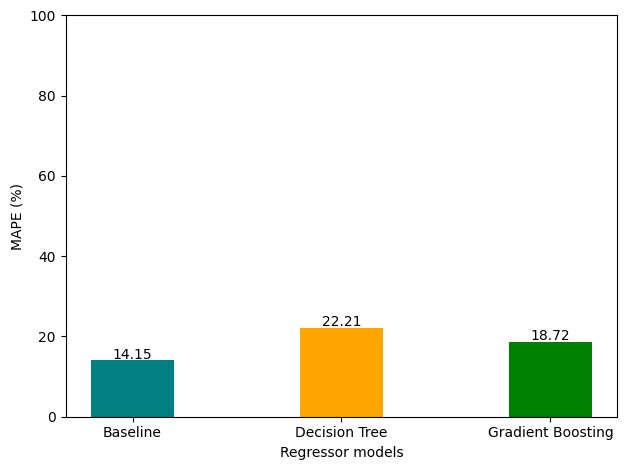

In [143]:
plot_bar(bp_mapes[1-1], dt_mapes[1-1], rc_mapes[1-1])

### Sequence of Pasts Predicts One Future

In [144]:
df_list = get_windows_range_input(df_conventional, "Small", WINDOWS)

In [145]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Small")
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)


In [146]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc_seq_input(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

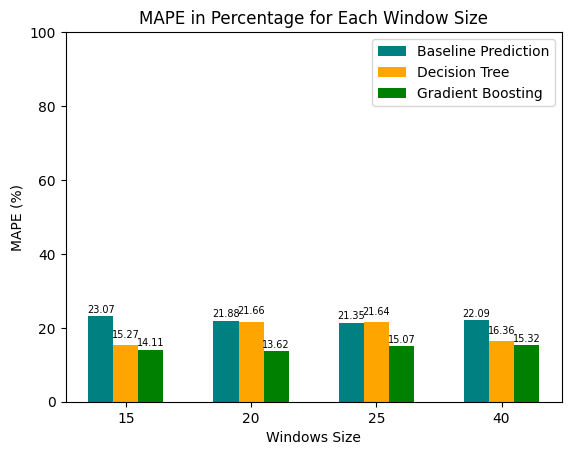

In [147]:
plot_mape_comparison(bp_mapes, dt_mapes, rc_mapes, WINDOWS)

### Sequence of Pasts Predicts Sequence of Futures

In [148]:
df_list = get_windows_range(df_conventional, "Small", WINDOWS)

In [149]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Small")
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)


In [150]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])
    

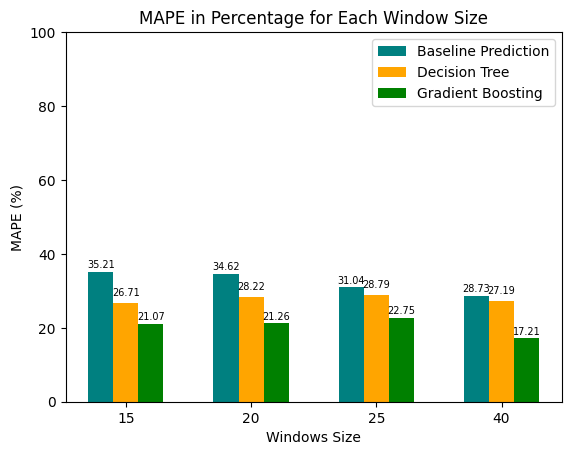

In [151]:
plot_mape_comparison(bp_mapes, dt_mapes, rc_mapes, WINDOWS)

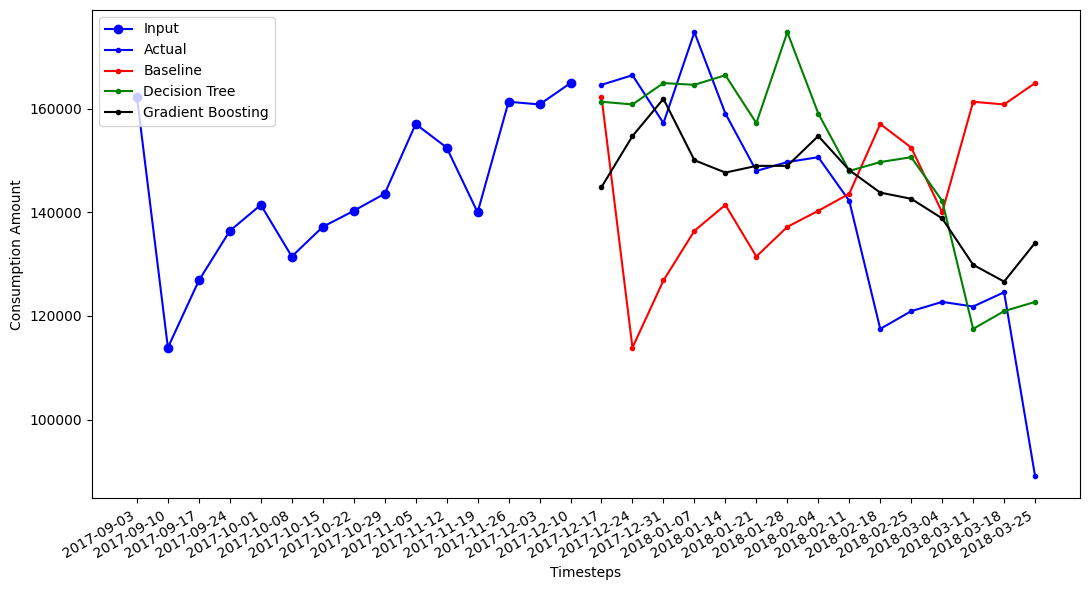

In [152]:
plot_line_graph(X_tests[0], y_tests[0], bp_preds[0], dt_preds[0], rc_preds[0])

## "Large" Apple

### One Past Predicts One Future

In [153]:
df_list = get_windows_range(df_conventional, "Large", [1])

In [154]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Large")
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)

In [155]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

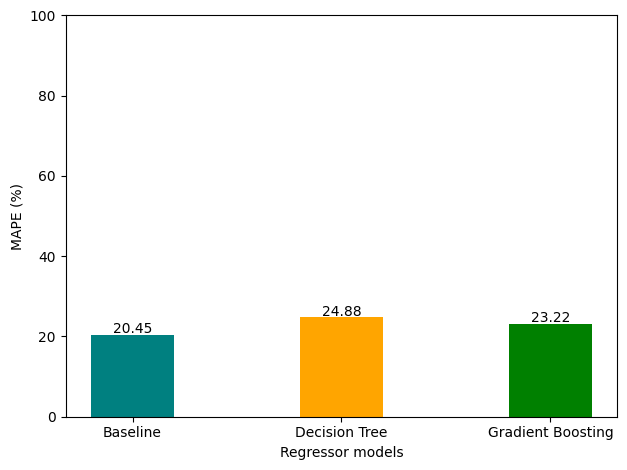

In [156]:
plot_bar(bp_mapes[1-1], dt_mapes[1-1], rc_mapes[1-1])

### Sequence of Pasts Predicts One Future

In [157]:
df_list = get_windows_range_input(df_conventional, "Large", WINDOWS)

In [158]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Large")
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)


In [159]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc_seq_input(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

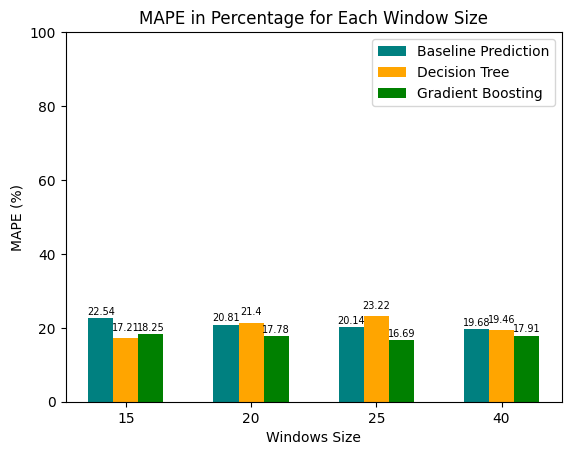

In [160]:
plot_mape_comparison(bp_mapes, dt_mapes, rc_mapes, WINDOWS)

### Sequence of Pasts Predicts Sequence of Futures

In [161]:
df_list = get_windows_range(df_conventional, "Large", WINDOWS)

In [162]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Large")
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)


In [163]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])
    

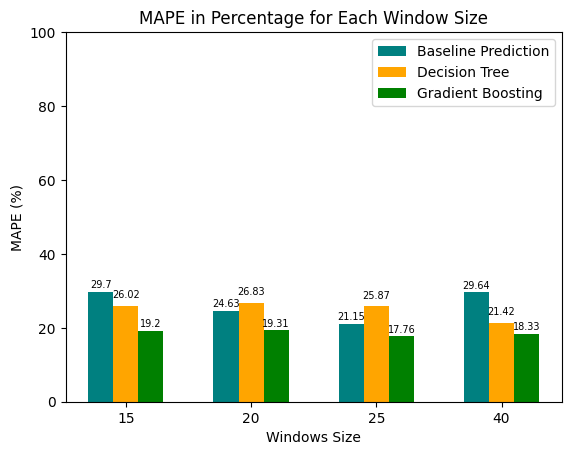

In [164]:
plot_mape_comparison(bp_mapes, dt_mapes, rc_mapes, WINDOWS)

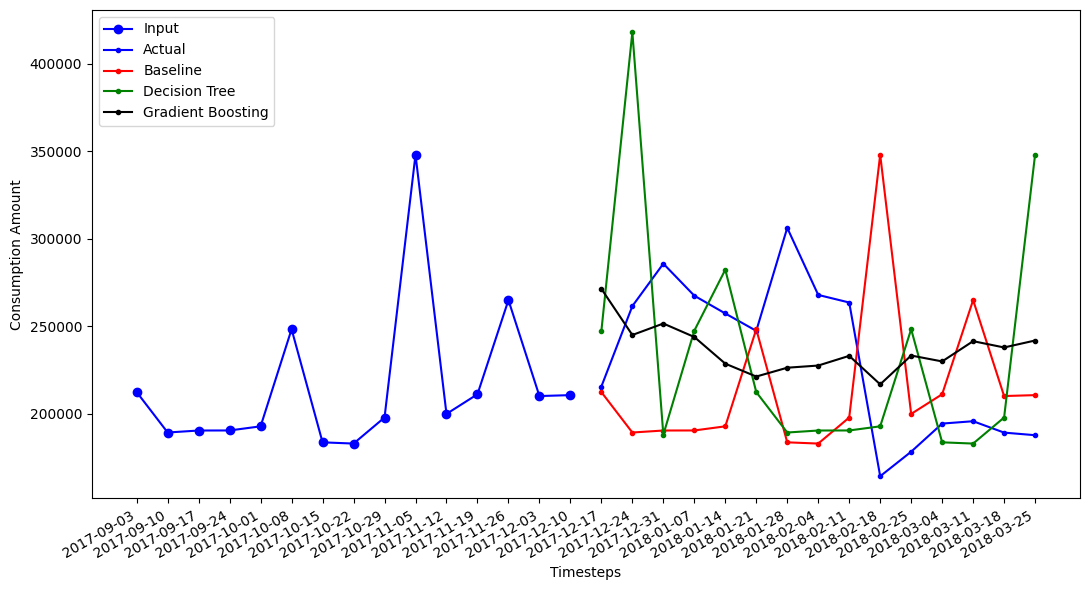

In [165]:
plot_line_graph(X_tests[0], y_tests[0], bp_preds[0], dt_preds[0], rc_preds[0])

# "Organic" Apple Type

In [166]:
df_organic = remove_unused_col(df_organic)
df_organic

,Date,Small,Large
0,2015-01-04,3727.52,4327.52
1,2015-01-11,4243.14,3033.84
2,2015-01-18,15363.18,20986.36
3,2015-01-25,4291.23,4741.77
4,2015-02-01,7103.90,5624.41
...,...,...,...
164,2018-02-25,2169.03,4285.39
165,2018-03-04,2391.35,3880.13
166,2018-03-11,2317.50,3561.20
167,2018-03-18,1954.32,3597.70


## "Small" Apple

### One Past Predicts One Future

In [167]:
df_list = get_windows_range(df_organic, "Small", [1])

In [168]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Small")
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)

In [169]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

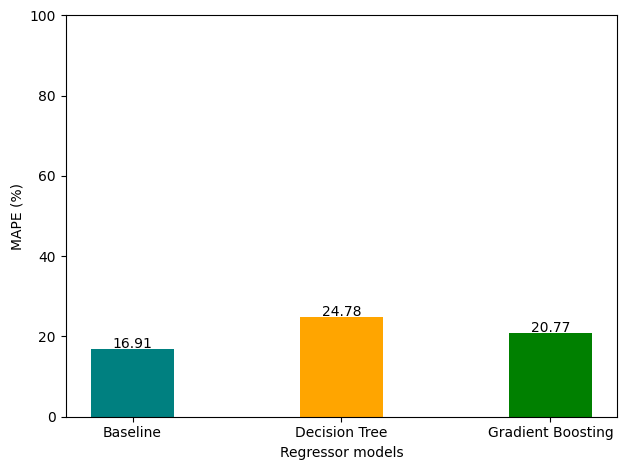

In [170]:
plot_bar(bp_mapes[1-1], dt_mapes[1-1], rc_mapes[1-1])

### Sequence of Pasts Predicts One Future

In [171]:
df_list = get_windows_range_input(df_organic, "Small", WINDOWS)

In [172]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Small")
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)


In [173]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc_seq_input(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

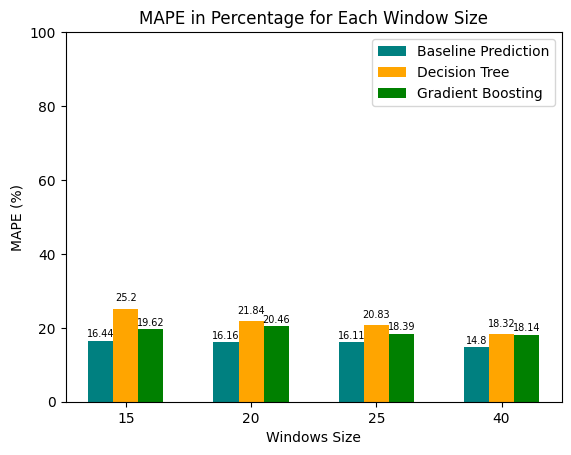

In [174]:
plot_mape_comparison(bp_mapes, dt_mapes, rc_mapes, WINDOWS)

### Sequence of Pasts Predicts Sequence of Futures

In [175]:
df_list = get_windows_range(df_organic, "Small", WINDOWS)

In [176]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Small")
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)


In [177]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])
    

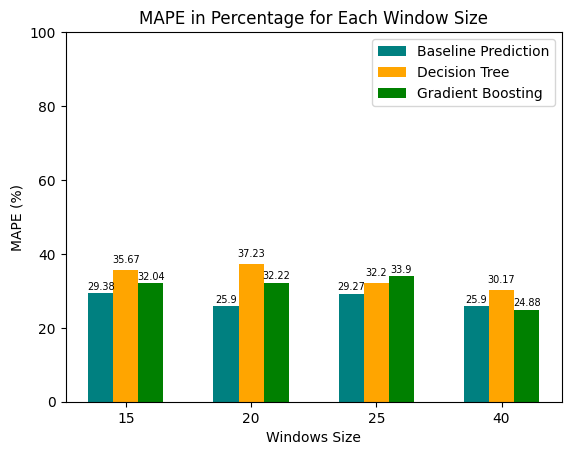

In [178]:
plot_mape_comparison(bp_mapes, dt_mapes, rc_mapes, WINDOWS)

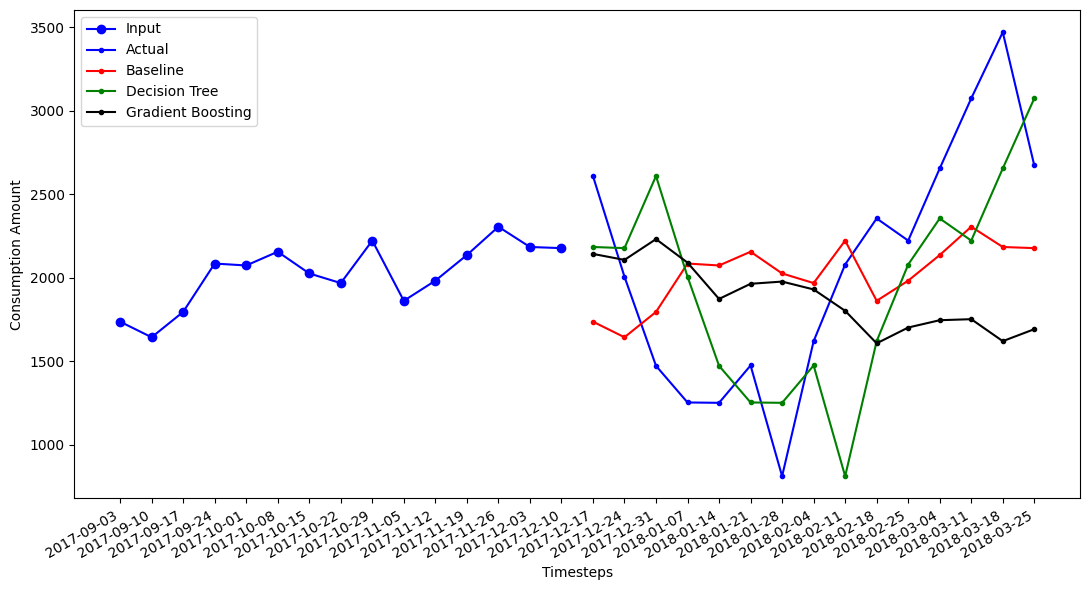

In [179]:
plot_line_graph(X_tests[0], y_tests[0], bp_preds[0], dt_preds[0], rc_preds[0])

## "Large" Apple

### One Past Predicts One Future

In [180]:
df_list = get_windows_range(df_organic, "Large", [1])

In [181]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Large")
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)

In [182]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

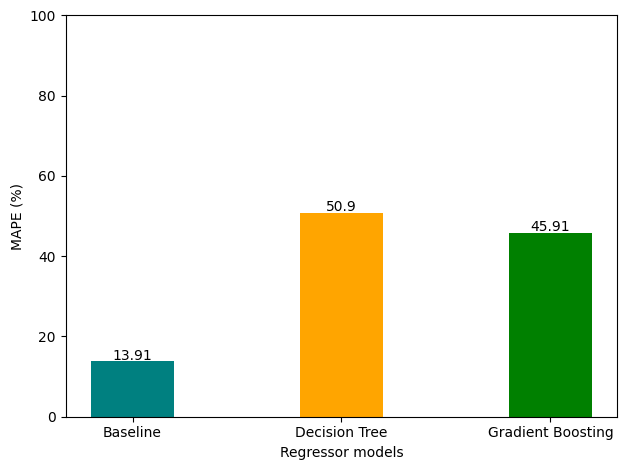

In [183]:
plot_bar(bp_mapes[1-1], dt_mapes[1-1], rc_mapes[1-1])

### Sequence of Pasts Predicts One Future

In [184]:
df_list = get_windows_range_input(df_organic, "Large", WINDOWS)

In [185]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Large")
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)


In [186]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc_seq_input(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])

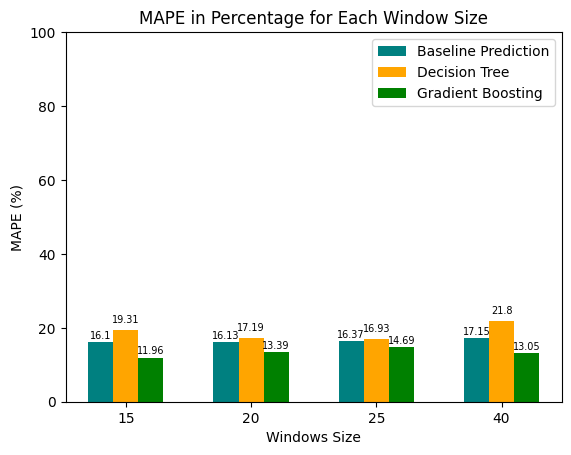

In [187]:
plot_mape_comparison(bp_mapes, dt_mapes, rc_mapes, WINDOWS)

### Sequence of Pasts Predicts Sequence of Futures

In [188]:
df_list = get_windows_range(df_organic, "Large", WINDOWS)

In [189]:
X_trains = list()
y_trains = list()
X_tests = list()
y_tests = list()

for df in df_list:
    X_train, X_test, y_train, y_test = train_test_split(df, "Large")
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_tests.append(X_test)
    y_tests.append(y_test)


In [190]:
bp_preds = list()
bp_mapes = list()

dt_preds = list()
dt_mapes = list()

rc_preds = list()
rc_mapes = list()

for i, v in enumerate(X_trains):
    bp = bp_calc(X_tests[i], y_tests[i])
    dt = dt_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    rc = rc_calc(X_trains[i], y_trains[i], X_tests[i], y_tests[i])
    bp_preds.append(bp[0])
    bp_mapes.append(bp[1])
    dt_preds.append(dt[0])
    dt_mapes.append(dt[1])
    rc_preds.append(rc[0])
    rc_mapes.append(rc[1])
    

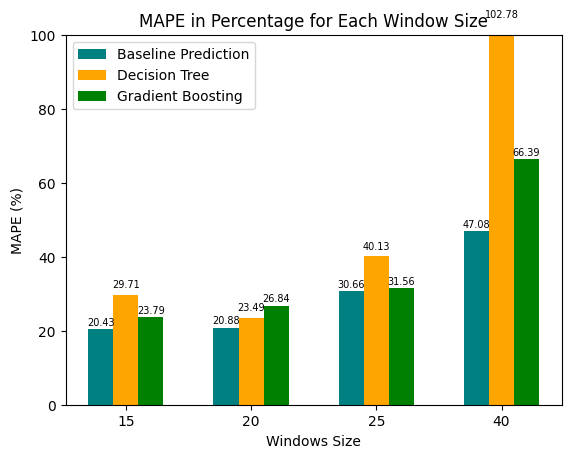

In [191]:
plot_mape_comparison(bp_mapes, dt_mapes, rc_mapes, WINDOWS)

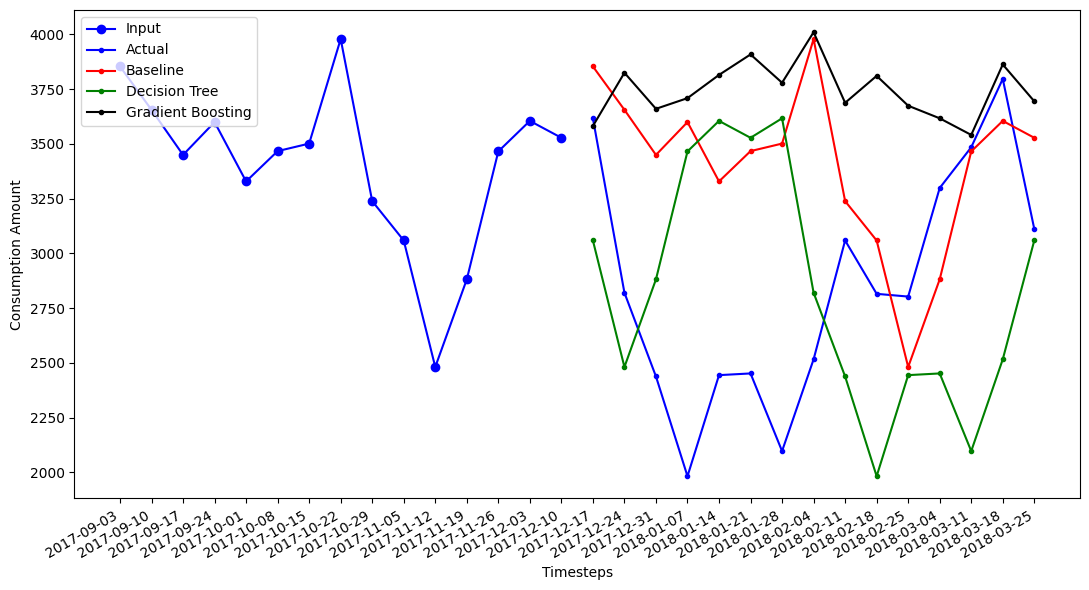

In [192]:
plot_line_graph(X_tests[0], y_tests[0], bp_preds[0], dt_preds[0], rc_preds[0])